<a href="https://colab.research.google.com/github/julia-lina-tan/rl-policy-fusion/blob/main/rl_policy_fusion_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook trains agents from Stable Baselines3 in the "Reacher" Gym environment.

1. An agent will be trained to reach for rewards in the 1st quadrant of the workspace
2. An agent will be trained to reach for rewards in the 2nd quadrant of the workspace
3. A fused agent will be initialised from these two previous agents using OT techniques
4. The fused agent will relearn to reach for rewards in both the 1st and 2nd quadrants of the workspace
5. The effectiveness of initialising via fusion (as compared to relearning from the original models or creating a new model from scratch) will be evaluated

# Setup

Install Stable Baselines and other dependencies.

In [1]:
!pip install stable-baselines3[extra]
!apt install swig cmake
!pip install stable-baselines3[extra] box2d box2d-kengz

     |████████████████████████████████| 153kB 7.7MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (764 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 160706 files and directories currently installed.)
Prepar

In [2]:
# Additional installations/imports for rendering Gym environment

!apt-get install -y xvfb x11-utils
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* 
!apt-get update
!apt-get install imagemagick

import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 994 kB in 1s (817 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 161497 files 

Install [pybullet-gym](https://github.com/benelot/pybullet-gym) and import Reacher environment.

In [3]:
!git clone https://github.com/openai/gym.git
!cd gym && pip install -e .

Cloning into 'gym'...
remote: Enumerating objects: 10880, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 10880 (delta 12), reused 19 (delta 10), pack-reused 10852
Receiving objects: 100% (10880/10880), 4.17 MiB | 11.23 MiB/s, done.
Resolving deltas: 100% (7363/7363), done.
Obtaining file:///content/gym
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
  Running setup.py develop for gym


In [4]:
!git clone https://github.com/benelot/pybullet-gym.git
!cd pybullet-gym && pip install -e . 

Cloning into 'pybullet-gym'...
remote: Enumerating objects: 804, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 804 (delta 21), reused 18 (delta 5), pack-reused 750
Receiving objects: 100% (804/804), 19.31 MiB | 18.91 MiB/s, done.
Resolving deltas: 100% (437/437), done.
Obtaining file:///content/pybullet-gym
     |████████████████████████████████| 79.0MB 70kB/s 
  Created wheel for pybullet: filename=pybullet-3.1.7-cp37-cp37m-linux_x86_64.whl size=89750823 sha256=be13bfdca18eb0732a21c9ea128cc9e77051d3c3c9ab5afce04accd545987b5d
  Stored in directory: /root/.cache/pip/wheels/30/56/e6/fce8276a2f30165f7ac31089bb72f390fa16b87328651e1a5a
Successfully built pybullet
  Running setup.py develop for pybulletgym


Restart local runtime for pybulletgym import to work.

In [1]:
import gym  # open ai gym
import pybulletgym  # register PyBullet enviroments with open ai gym

env = gym.make('ReacherPyBulletEnv-v0')
env.reset()  # should return a state vector if everything worked

print(env.action_space)
print(env.observation_space)

Box(-1.0, 1.0, (2,), float32)
Box(-inf, inf, (9,), float32)


/content/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Configure target location

Configure valid spaces so we can train different agents on different quadrants.

The first agent will only be able to reach targets in the first quadrant only.

In [2]:
def custom_first_quadrant(robot, __p):

    minX = -0.27
    maxX = 0
    minY = 0
    maxY = 0.27
    
    robot.jdict['target_x'].reset_current_position(
        robot.np_random.uniform(low=minX, high=maxX), 0)
    
    robot.jdict['target_y'].reset_current_position(
        robot.np_random.uniform(low=minY, high=maxY), 0)
    
    robot.fingertip = robot.parts["fingertip"]
    robot.target = robot.parts["target"]
    robot.central_joint = robot.jdict["joint0"]
    robot.elbow_joint = robot.jdict["joint1"]
    robot.central_joint.reset_current_position(robot.np_random.uniform(low=-3.14, high=3.14), 0)
    robot.elbow_joint.reset_current_position(robot.np_random.uniform(low=-3.14, high=3.14), 0)

Overwrite existing method so that we can configure the target locations.

In [3]:
import types

def overwrite_method(custom_foo, env):
  env.robot.robot_specific_reset = types.MethodType(custom_foo, env.robot)

overwrite_method(custom_first_quadrant, env)

In [4]:
env.reset()

array([-0.14623785,  0.05318179,  0.22421372,  0.08335503, -0.24641059,
        0.96916553,  0.        , -0.48376864,  0.        ])

Import RL policy, RL agents and wrappers.

In [5]:
import os
import numpy as np
import torch as pt
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

## Rendering agent in environment

In [6]:
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import animation

def env_render(env):
    view_matrix = env.robot._p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[0,0,0.05],
                                                      distance=0.7,
                                                      yaw=0,
                                                      pitch=-90,
                                                      roll=0,
                                                      upAxisIndex=2)
    proj_matrix = env.robot._p.computeProjectionMatrixFOV(fov=60,
                                                  aspect=float(960) /720,
                                                  nearVal=0.1,
                                                  farVal=100.0)
    (_, _, px, _, _) = env.robot._p.getCameraImage(width=960,
                                          height=720,
                                          viewMatrix=view_matrix,
                                          projectionMatrix=proj_matrix,
                                          renderer=env.robot._p.ER_BULLET_HARDWARE_OPENGL)

    rgb_array = np.array(px, dtype=np.uint8)
    rgb_array = np.reshape(rgb_array, (720,960, 4))
    rgb_array = rgb_array[:, :, :3]
    return rgb_array

def save_frames_as_gif(frames, path='../content', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

def render_agent_in_env(agent, env, n_eval_episodes=5, path='../content', filename='gym_animation'):
    for i in range(n_eval_episodes):
      frames = []
      obs = env.reset()
      for t in range(500):

          #Render to frames buffer
          frame = env_render(env)
          cv2.putText(frame, text=f'Episode {i+1}', org=(50,50), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=0.8, color=(0,0,0))
          frames.append(frame)
          action, _states = agent.predict(obs)
          obs, rewards, done, info = env.step(action)
          if done:
            break
      save_frames_as_gif(frames, path=path, filename=f'{filename}-ep{i+1}.gif')

## Extracting policy from model parameters

In [7]:
def get_weights(model, net='policy'):
    """
    Get weights of policy/action/value net.

    :param model: (dict) the MLP policy model 
    :param net: (str) policy/action/value
    """
    policy = model.get_parameters()['policy']

    if net == 'policy':
        layer_weights = [policy['mlp_extractor.policy_net.0.weight'], policy['mlp_extractor.policy_net.2.weight']]
    else:
        layer_weights = [policy[f'{net}_net.weight']]

    return [layer.numpy() for layer in layer_weights]

# Train agent

Get learning curve from training episodes.

In [8]:
from stable_baselines3.common.monitor import load_results
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import *
X_TIMESTEPS = 'timesteps'
X_EPISODES = 'episodes'
X_WALLTIME = 'walltime_hrs'
POSSIBLE_X_AXES = [X_TIMESTEPS, X_EPISODES, X_WALLTIME]
EPISODES_WINDOW = 100
COLORS = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'pink',
          'brown', 'orange', 'teal', 'coral', 'lightblue', 'lime', 'lavender', 'turquoise',
          'darkgreen', 'tan', 'salmon', 'gold', 'lightpurple', 'darkred', 'darkblue']

def plot_training_curve(dirs, num_timesteps, xaxis, task_name, legend=None):
    """
    plot the results

    :param dirs: ([str]) the save location of the results to plot
    :param num_timesteps: (int or None) only plot the points below this value
    :param xaxis: (str) the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :param task_name: (str) the title of the task to plot
    """

    tslist = []
    for folder in dirs:
        timesteps = load_results(folder)
        if num_timesteps is not None:
            timesteps = timesteps[timesteps.l.cumsum() <= num_timesteps]
        tslist.append(timesteps)
    xy_list = [ts2xy(timesteps_item, xaxis) for timesteps_item in tslist]
    plot_curve(xy_list, xaxis, task_name, legend)

def plot_curve(xy_list, xaxis, title, legend):
    """
    plot the curve

    :param xy_list: ([(np.ndarray, np.ndarray)]) the x and y coordinates to plot
    :param xaxis: (str) the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :param title: (str) the title of the plot
    """

    plt.figure(figsize=(8, 2))
    maxx = max(xy[0][-1] for xy in xy_list)
    minx = 0
    for (i, (x, y)) in enumerate(xy_list):
        color = COLORS[i]
        # plt.plot(x, y)
        # Do not plot the smoothed curve at all if the timeseries is shorter than window size.
        if x.shape[0] >= EPISODES_WINDOW:
            # Compute and plot rolling mean with window of size EPISODE_WINDOW
            x, y_mean = window_func(x, y, EPISODES_WINDOW, np.mean)
            plt.plot(x, y_mean, color=color)
    plt.xlim(minx, maxx)
    plt.title(title)
    plt.xlabel(xaxis)
    plt.ylabel("Episode Rewards")
    if legend is not None:
        plt.legend(legend, bbox_to_anchor=(1.04,1), loc="upper left")

Streaming output truncated to the last 5000 lines.
|    loss                 | 3.36         |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00505     |
|    std                  | 0.856        |
|    value_loss           | 7.97         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 150         |
|    ep_rew_mean          | -5.19       |
| time/                   |             |
|    fps                  | 740         |
|    iterations           | 19          |
|    time_elapsed         | 52          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.004825873 |
|    clip_fraction        | 0.0679      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.51       |
|    explained_variance   | 0.839       |
|    learning_rate        | 0.0003      |
|    loss          

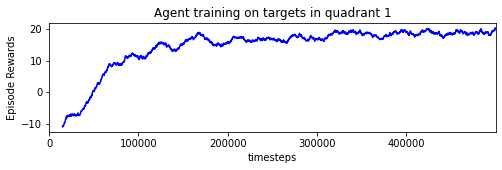

In [9]:
log_dir = '../content/agent1/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

model_one = PPO('MlpPolicy', env, verbose=1, seed=1)
timesteps = 5e5
model_one.learn(total_timesteps=timesteps)

plot_training_curve([log_dir], timesteps, results_plotter.X_TIMESTEPS, "Agent training on targets in quadrant 1")
plt.show()

## Get layer weights of policy net

In [10]:
policy_weights = get_weights(model_one, net='policy')

Get weights of action net (i.e. actor layer of the policy).

In [11]:
action_weights = get_weights(model_one, net='action')
policy_weights.append(action_weights[0])

policy_weights_all = [policy_weights]
print([layer.shape for layer in policy_weights])

[(64, 9), (64, 64), (2, 64)]


# Test agent

Test on separate evaluation environment.

In [12]:
from stable_baselines3.common.evaluation import evaluate_policy

def plot_rewards(mean_reward, title=None):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Rewards at episode')
    plt.xticks(list(range(1, len(mean_reward)+1)))
    plt.plot(list(range(1, len(mean_reward)+1)), mean_reward, marker='o')
    plt.show()

/content/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=20.10 +/- 6.80


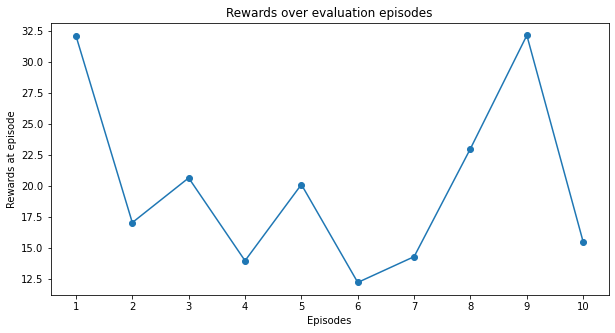

In [13]:
# Create separate evaluation environment
eval_env = gym.make('ReacherPyBulletEnv-v0')
overwrite_method(custom_first_quadrant, eval_env)
eval_env.reset()

ep_rewards, ep_steps = evaluate_policy(model_one, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

Visualise the performance of the agent over a number of evaluation episodes.

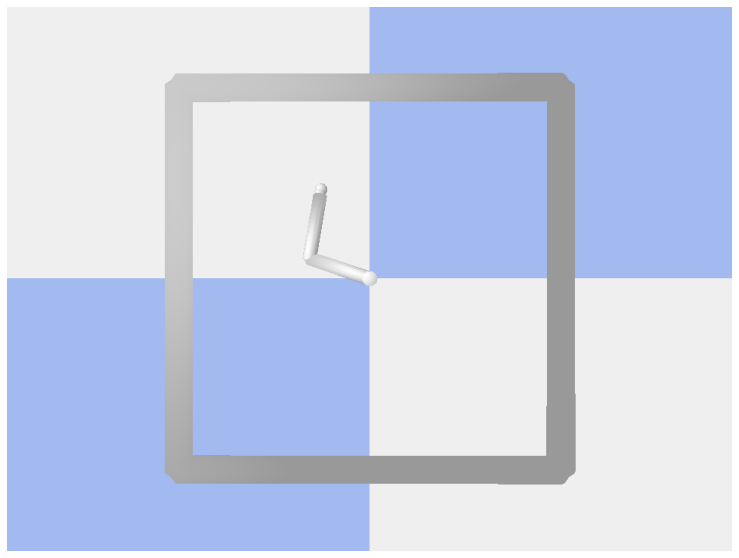

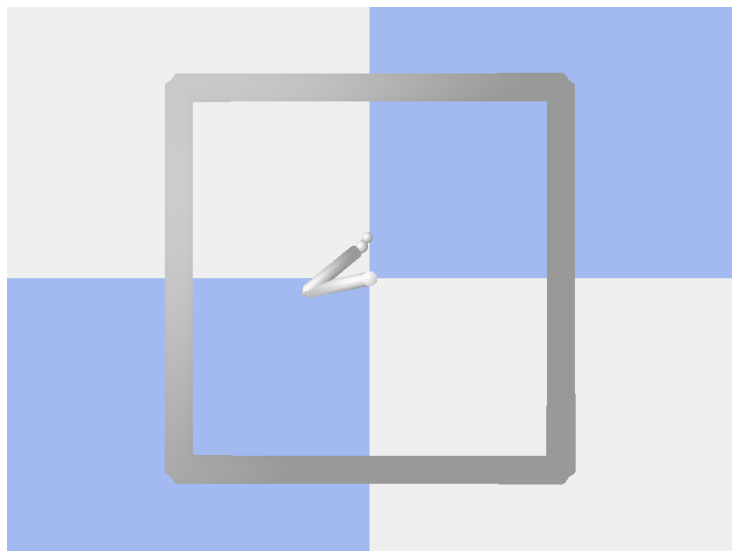

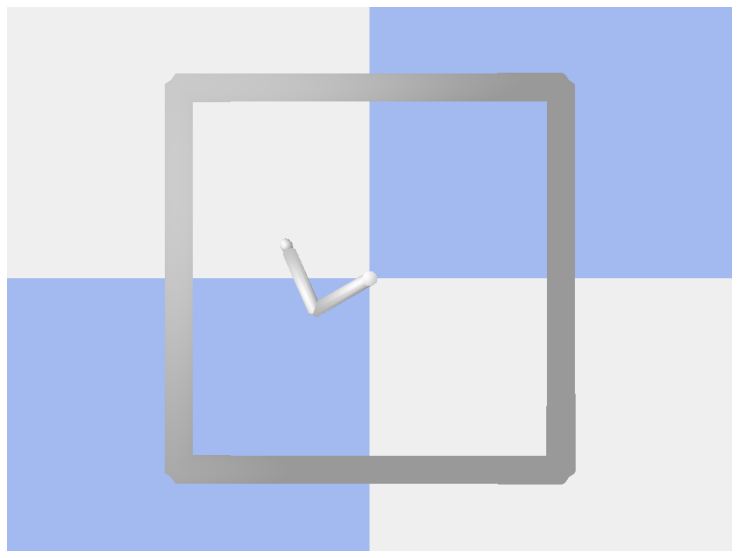

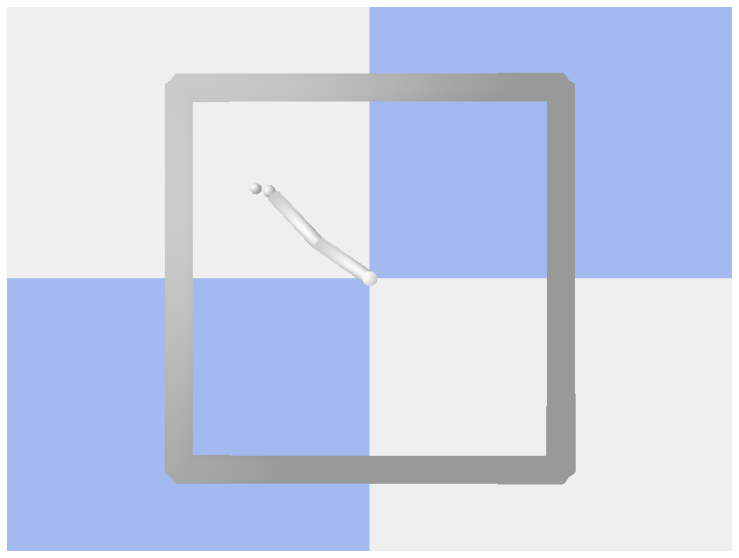

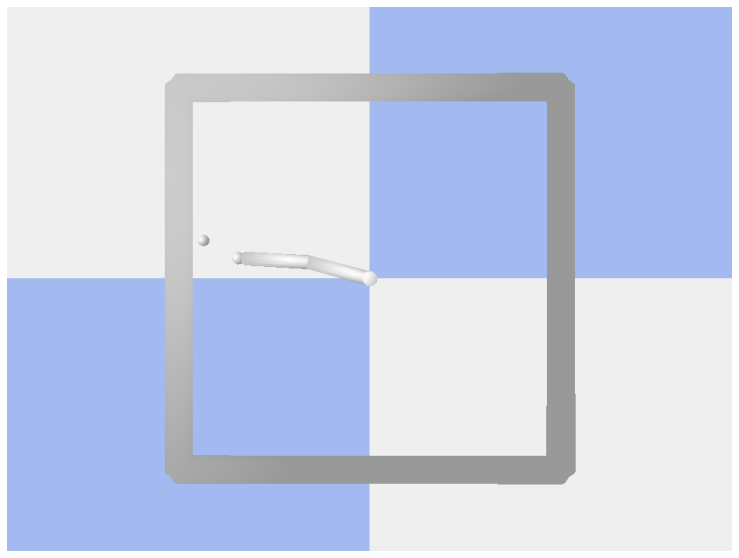

In [14]:
os.makedirs('../content/agent1/rendering/', exist_ok=True)
render_agent_in_env(model_one, eval_env, n_eval_episodes=5, path='../content/agent1/rendering/', filename='agent1')

# Create second agent

This agent will be trained to reach targets in the second quadrant only.

In [15]:
def custom_second_quadrant(robot, __p):

    minX = 0
    maxX = 0.27
    minY = 0
    maxY = 0.27
    
    robot.jdict['target_x'].reset_current_position(
        robot.np_random.uniform(low=minX, high=maxX), 0)
    
    robot.jdict['target_y'].reset_current_position(
        robot.np_random.uniform(low=minY, high=maxY), 0)
    
    robot.fingertip = robot.parts["fingertip"]
    robot.target = robot.parts["target"]
    robot.central_joint = robot.jdict["joint0"]
    robot.elbow_joint = robot.jdict["joint1"]
    robot.central_joint.reset_current_position(robot.np_random.uniform(low=-3.14, high=3.14), 0)
    robot.elbow_joint.reset_current_position(robot.np_random.uniform(low=-3.14, high=3.14), 0)

In [16]:
env = gym.make('ReacherPyBulletEnv-v0')
overwrite_method(custom_second_quadrant, env)
env.reset()

/content/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([ 0.20157577,  0.04816583, -0.08874055, -0.04171868,  0.42113817,
        0.90699649,  0.        , -0.66952866,  0.        ])

Create another agent and train it on the different environment.

Streaming output truncated to the last 5000 lines.
|    loss                 | 4.57        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00886    |
|    std                  | 0.884       |
|    value_loss           | 8.22        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 150         |
|    ep_rew_mean          | -4.08       |
| time/                   |             |
|    fps                  | 732         |
|    iterations           | 19          |
|    time_elapsed         | 53          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.011156539 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.59       |
|    explained_variance   | 0.693       |
|    learning_rate        | 0.0003      |
|    loss                

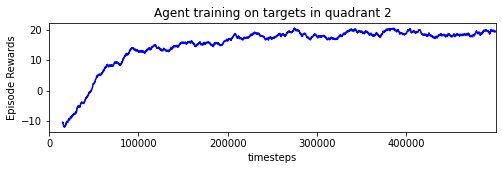

In [17]:
log_dir = '../content/agent2/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

model_two = PPO('MlpPolicy', env, verbose=1, seed=1)
timesteps=5e5
model_two.learn(total_timesteps=timesteps)

plot_training_curve([log_dir], timesteps, results_plotter.X_TIMESTEPS, "Agent training on targets in quadrant 2")
plt.show()

Get layer weights of policy net and action net.

In [18]:
policy_weights = get_weights(model_two, net='policy')
action_weights = get_weights(model_two, net='action')
policy_weights.append(action_weights[0])

policy_weights_all.append(policy_weights)
print([layer.shape for layer in policy_weights])

[(64, 9), (64, 64), (2, 64)]


Test second agent on a separate evaluation environment.

/content/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=19.56 +/- 10.06


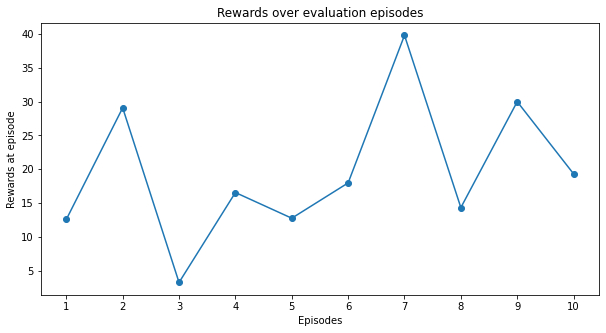

In [19]:
# Create separate evaluation environment
eval_env = gym.make('ReacherPyBulletEnv-v0')
overwrite_method(custom_second_quadrant, eval_env)
eval_env.reset()

ep_rewards, ep_steps = evaluate_policy(model_two, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

Visualise the performance of the agent over a number of evaluation episodes.

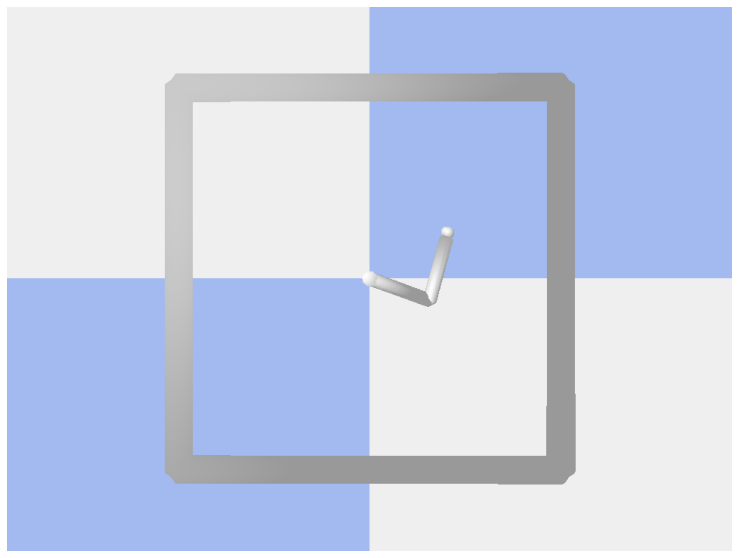

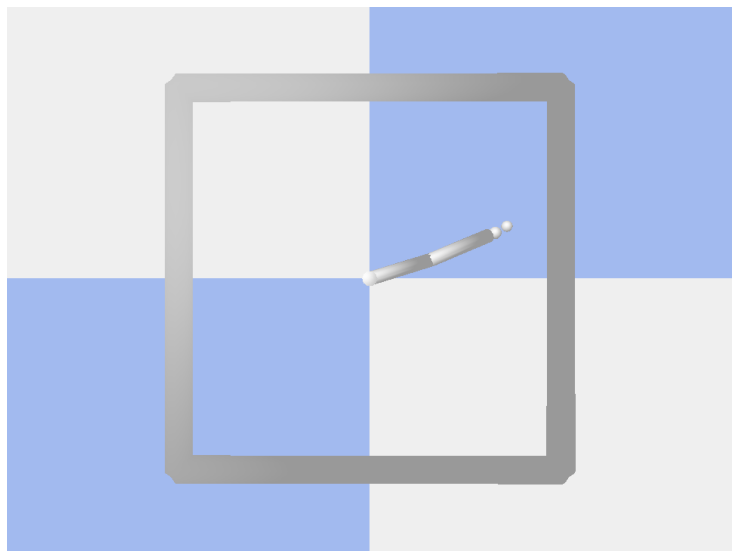

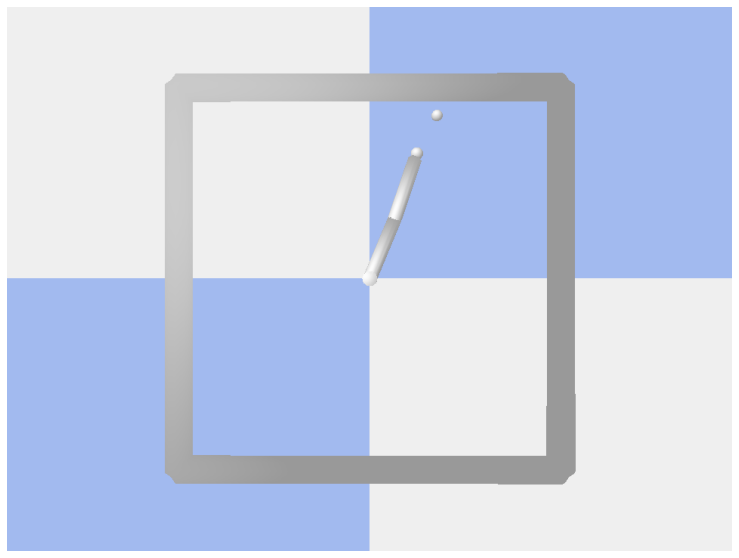

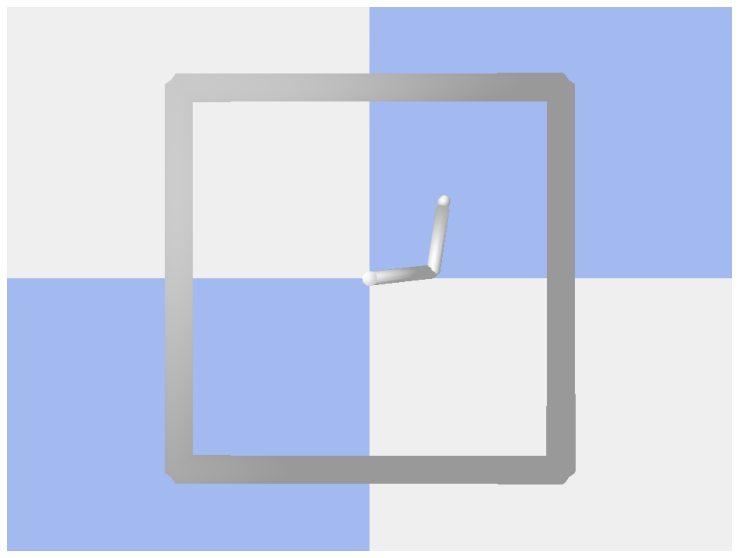

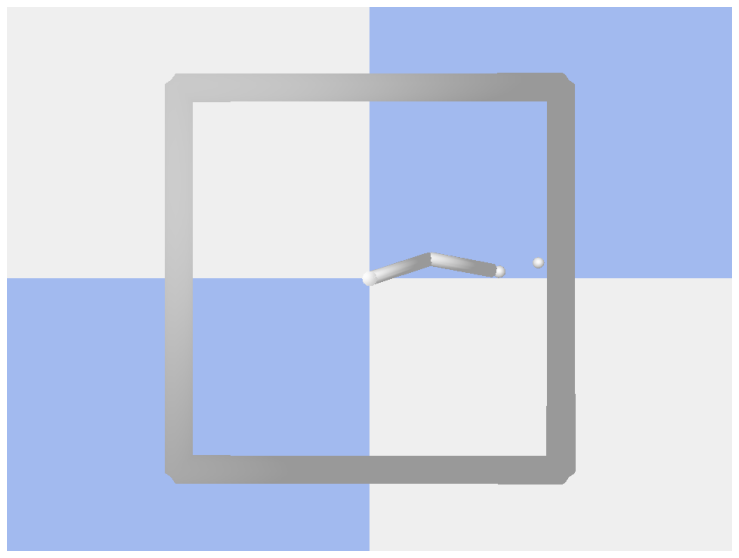

In [20]:
os.makedirs('../content/agent2/rendering/', exist_ok=True)
render_agent_in_env(model_two, eval_env, n_eval_episodes=5, path='../content/agent2/rendering/', filename='agent2')

# Fuse the agents

## Align layers using OT

Compute the OT transport map between the weights, then align the matching nodes to each other using this map.

In [21]:
# Install optimal transport requirements
!pip install pot
import ot

     |████████████████████████████████| 440kB 7.6MB/s 


In [22]:
def align_nodes(layer_weights_all, stop_layer_k=3):
    
    # Compute layer-wise transport maps
    for i in range(stop_layer_k):

        # Align other nets (source) to first net (target)
        for j in range(1, len(layer_weights_all)):
            Xs = layer_weights_all[j][i]
            Xt = layer_weights_all[0][i]

            # Reorganise source weights according to previous layer alignment
            if i > 0:
              for pos, w in enumerate(Xs):
                Xs[pos] = w[alignment_idx]

            # Compute optimal transport map using EMD, since matching whole nodes
            ot_emd = ot.da.EMDTransport()
            ot_emd.fit(Xs=Xs, Xt=Xt)

            # Get source net aligned to node positions of target net
            aligned_Xs = ot_emd.inverse_transform(Xt=Xt)

            # Replace original with aligned 
            layer_weights_all[j][i] = aligned_Xs

            # Save as previous layer alignment
            alignment_idx = []
            for w in range(Xs.shape[0]):
              idx = np.argwhere(aligned_Xs == Xs[w])[0][0]
              alignment_idx.append(idx)

    return layer_weights_all

aligned_policy_weights_all = align_nodes(policy_weights_all, stop_layer_k=3)

## Average weights
Average layer weights to fuse the aligned neurons.

In [23]:
def fuse_policy_weights(aligned_policy_weights_all):
    sum_weights = [np.add(aligned_policy_weights_all[0][0], 
                          aligned_policy_weights_all[1][0]), 
                   np.add(aligned_policy_weights_all[0][1], 
                          aligned_policy_weights_all[1][1]),
                   np.add(aligned_policy_weights_all[0][2],
                          aligned_policy_weights_all[1][2])]
    return [layer/2 for layer in sum_weights]

fused_policy_weights = fuse_policy_weights(aligned_policy_weights_all)

# Evaluate the fused model

We will evaluate the performance of the fused model on a Reacher environment where targets may be placed anywhere in the first or second quadrants.

In [24]:
def custom_both_quadrants(robot, __p):

    minX = -0.27
    maxX = 0.27
    minY = 0
    maxY = 0.27
    
    robot.jdict['target_x'].reset_current_position(
        robot.np_random.uniform(low=minX, high=maxX), 0)
    
    robot.jdict['target_y'].reset_current_position(
        robot.np_random.uniform(low=minY, high=maxY), 0)
    
    robot.fingertip = robot.parts["fingertip"]
    robot.target = robot.parts["target"]
    robot.central_joint = robot.jdict["joint0"]
    robot.elbow_joint = robot.jdict["joint1"]
    robot.central_joint.reset_current_position(robot.np_random.uniform(low=-3.14, high=3.14), 0)
    robot.elbow_joint.reset_current_position(robot.np_random.uniform(low=-3.14, high=3.14), 0)

# Create separate evaluation environment
eval_env = gym.make('ReacherPyBulletEnv-v0')
overwrite_method(custom_both_quadrants, eval_env)
eval_env.reset()

/content/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([-0.12015003,  0.06607481,  0.05810607,  0.00267111,  0.46126178,
        0.88726409,  0.        ,  0.74428929,  0.        ])

In [25]:
def replace_policy(model, new_policy, new_actor):

    # Replace policy net with given policy
    policy = model.get_parameters().get('policy')
    policy['mlp_extractor.policy_net.0.weight'] = pt.from_numpy(new_policy[0])
    policy['mlp_extractor.policy_net.2.weight'] = pt.from_numpy(new_policy[1])
    policy['action_net.weight'] = pt.from_numpy(new_actor)
    updated_param = {'policy': policy}

    # Set policy parameter 
    model.set_parameters(updated_param, exact_match=False)
    return model


env = gym.make('ReacherPyBulletEnv-v0')
overwrite_method(custom_both_quadrants, env)
env.reset()

# Make a new model from fused layers
log_dir = '../content/fused/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

fused_model = PPO('MlpPolicy', env, verbose=1, seed=1)
new_policy = fused_policy_weights[:-1]
new_actor = fused_policy_weights[-1]
fused_model = replace_policy(fused_model, new_policy, new_actor)

Using cpu device
Wrapping the env in a DummyVecEnv.


/content/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Without retraining

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=-2.34 +/- 7.57


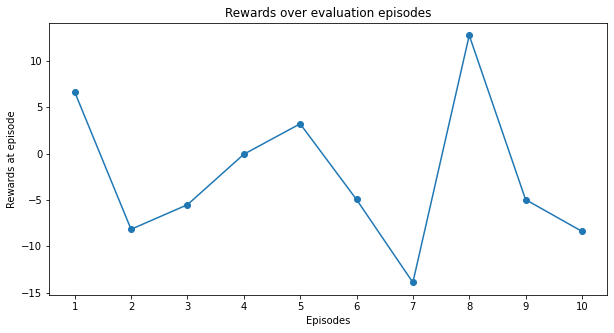

In [26]:
ep_rewards, ep_steps = evaluate_policy(fused_model, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

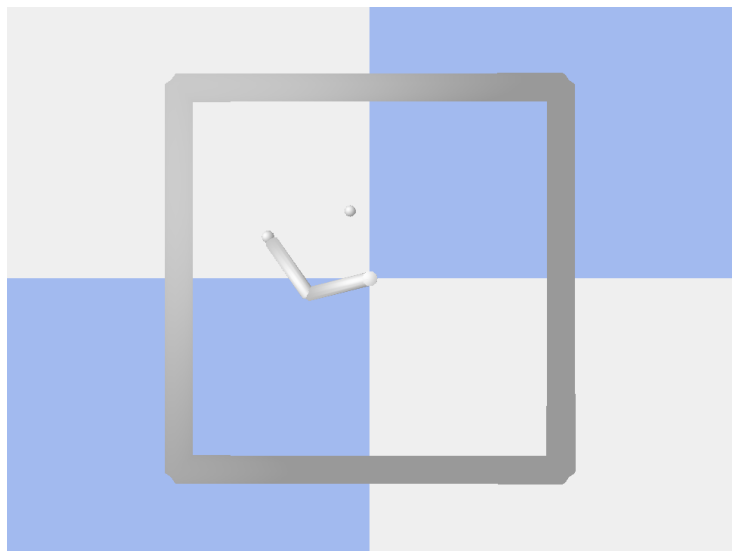

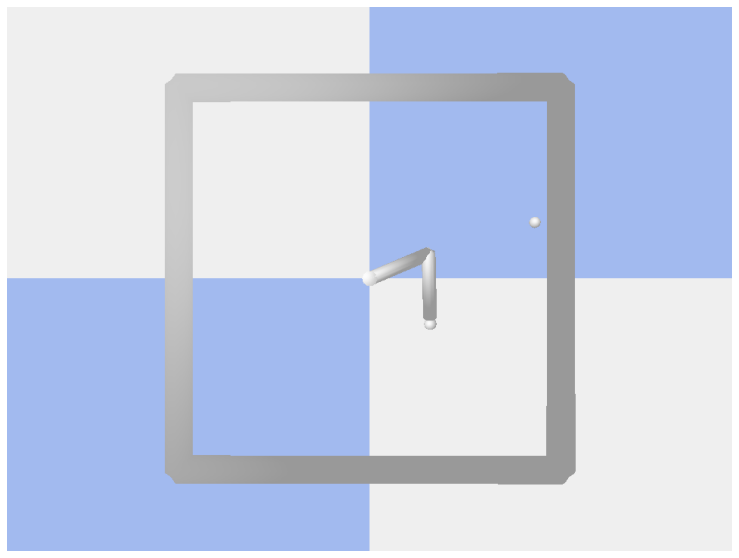

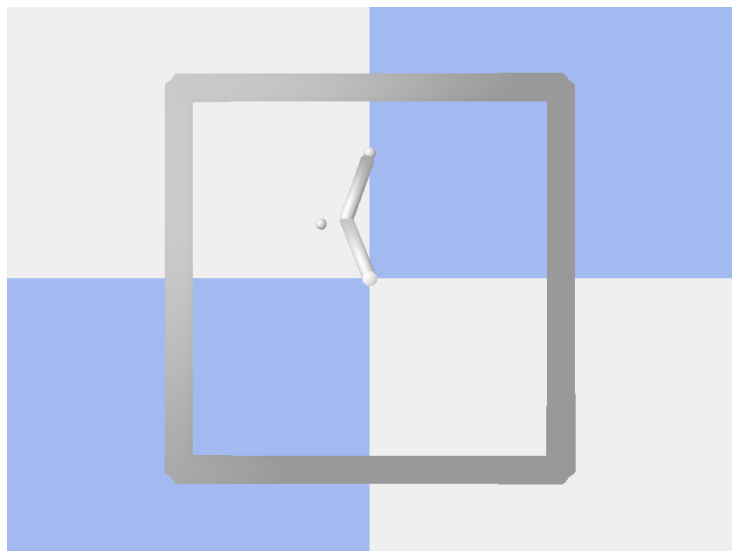

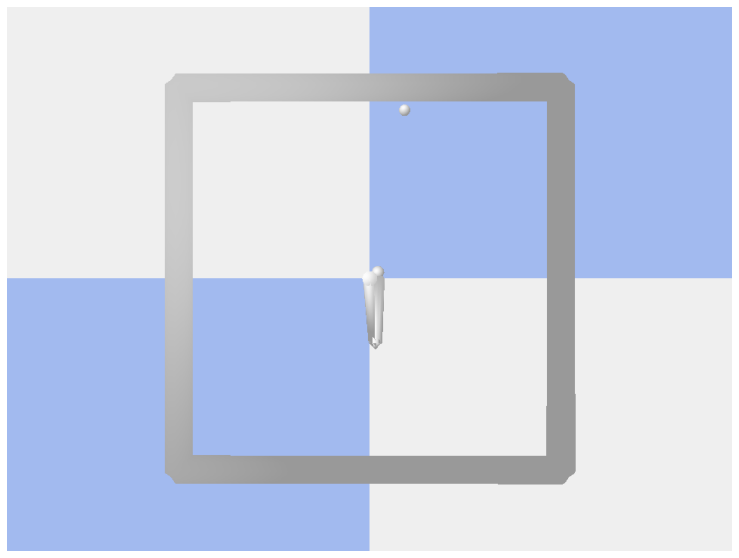

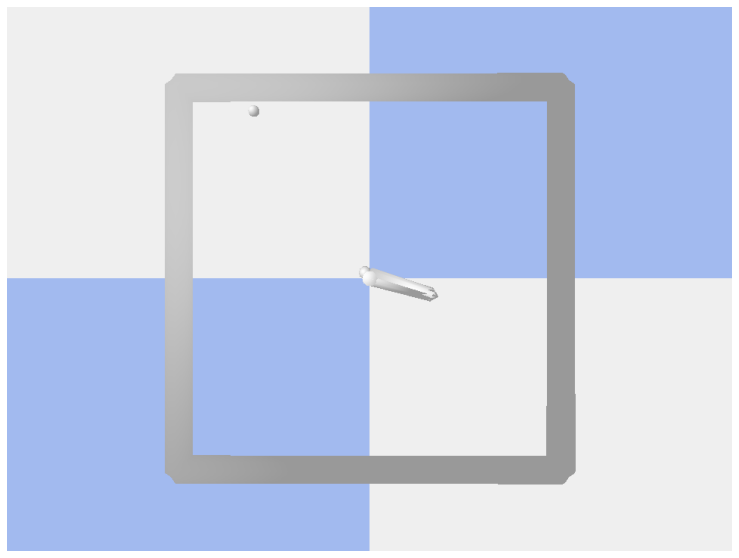

In [27]:
os.makedirs('../content/fused/rendering/', exist_ok=True)
render_agent_in_env(fused_model, eval_env, n_eval_episodes=5, path='../content/fused/rendering/', filename='untrained')

## With retraining

Retrain fused model to optimise weights.

In [28]:
timesteps = 5e5
fused_model.learn(total_timesteps=timesteps)

Streaming output truncated to the last 5000 lines.
|    loss                 | 3.6          |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00785     |
|    std                  | 0.835        |
|    value_loss           | 6.81         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 150         |
|    ep_rew_mean          | 4.67        |
| time/                   |             |
|    fps                  | 700         |
|    iterations           | 19          |
|    time_elapsed         | 55          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.004147142 |
|    clip_fraction        | 0.0536      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.47       |
|    explained_variance   | 0.805       |
|    learning_rate        | 0.0003      |
|    loss          

Compare to training model from scratch.

In [29]:
env = gym.make('ReacherPyBulletEnv-v0')
overwrite_method(custom_both_quadrants, env)
env.reset()

log_dir = '../content/new-agent/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

new_model = PPO('MlpPolicy', env, verbose=1, seed=1)
timesteps=5e5
new_model.learn(total_timesteps=timesteps)

/content/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Streaming output truncated to the last 5000 lines.
|    loss                 | 3.72         |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00503     |
|    std                  | 0.863        |
|    value_loss           | 7.07         |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 150          |
|    ep_rew_mean          | -10.9        |
| time/                   |              |
|    fps                  | 713          |
|    iterations           | 19           |
|    time_elapsed         | 54           |
|    total_timesteps      | 38912        |
| train/                  |              |
|    approx_kl            | 0.0065527437 |
|    clip_fraction        | 0.0757       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.53        |
|    explained_variance   | 0.392        |
|    learning_rate        | 0.0003       |
|  

Compare to retraining original models.

In [30]:
env = gym.make('ReacherPyBulletEnv-v0')
overwrite_method(custom_both_quadrants, env)
env.reset()

log_dir = '../content/agent1/retraining/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

model_one.set_env(env)
timesteps = 5e5
model_one.learn(total_timesteps=timesteps)

/content/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Streaming output truncated to the last 5000 lines.
|    loss                 | 0.469       |
|    n_updates            | 2620        |
|    policy_gradient_loss | 0.00356     |
|    std                  | 0.116       |
|    value_loss           | 1.49        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 150         |
|    ep_rew_mean          | 11.3        |
| time/                   |             |
|    fps                  | 706         |
|    iterations           | 19          |
|    time_elapsed         | 55          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.019521259 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.52        |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.0003      |
|    loss                

In [31]:
env = gym.make('ReacherPyBulletEnv-v0')
overwrite_method(custom_both_quadrants, env)
env.reset()

log_dir = '../content/agent2/retraining/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

model_two.set_env(env)
timesteps = 5e5
model_two.learn(total_timesteps=timesteps)

/content/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Streaming output truncated to the last 5000 lines.
|    loss                 | 0.141       |
|    n_updates            | 2620        |
|    policy_gradient_loss | 0.00409     |
|    std                  | 0.116       |
|    value_loss           | 0.284       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 150         |
|    ep_rew_mean          | 8.5         |
| time/                   |             |
|    fps                  | 703         |
|    iterations           | 19          |
|    time_elapsed         | 55          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.019884376 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.52        |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                

Plot all training curves on the same axes.

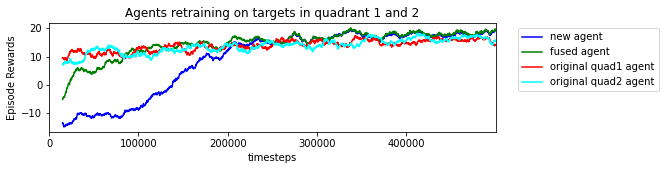

In [32]:
all_dirs = ['../content/new-agent/results/', '../content/fused/results/', '../content/agent1/retraining/results/', '../content/agent2/retraining/results']
legend = ['new agent', 'fused agent', 'original quad1 agent', 'original quad2 agent']
plot_training_curve(all_dirs, timesteps, results_plotter.X_TIMESTEPS, "Agents retraining on targets in quadrant 1 and 2", legend=legend)

## Evaluation and rendering

Fused model:

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=17.05 +/- 7.37


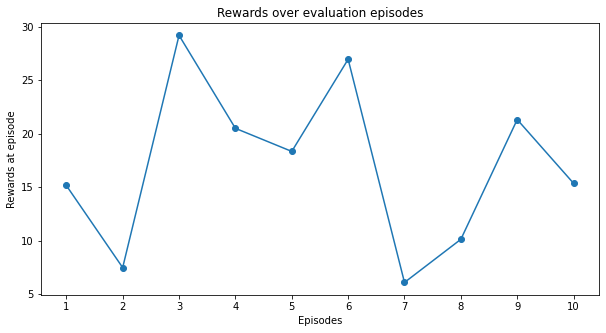

In [33]:
ep_rewards, ep_steps = evaluate_policy(fused_model, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

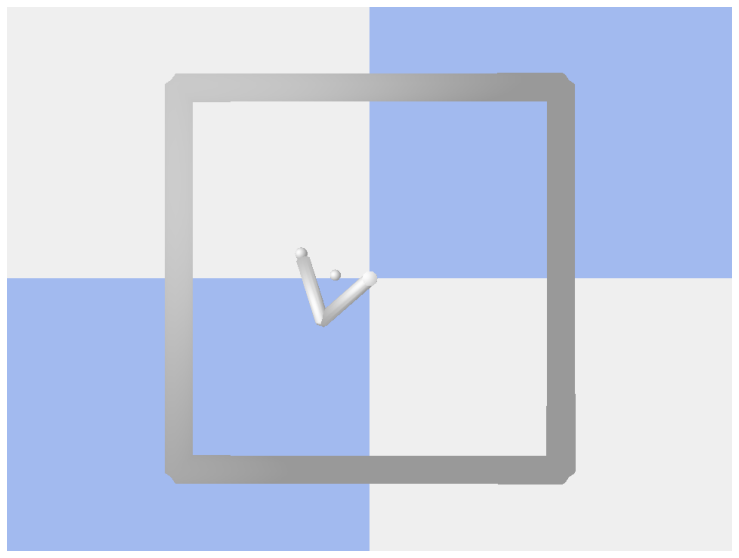

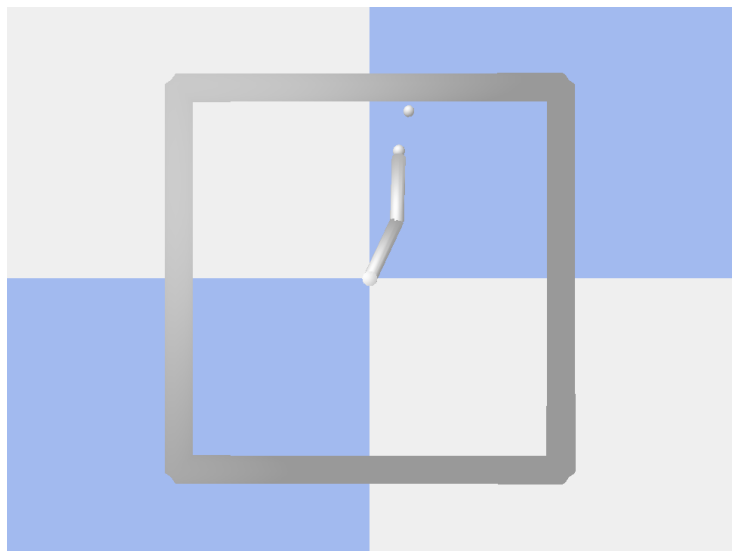

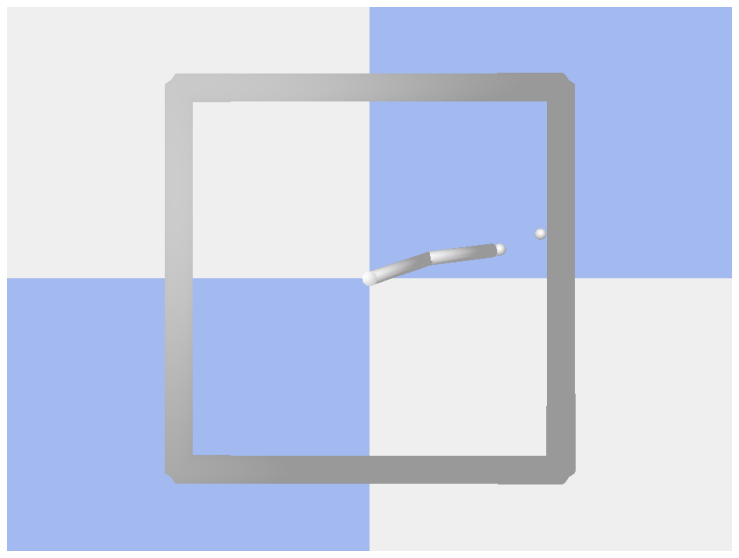

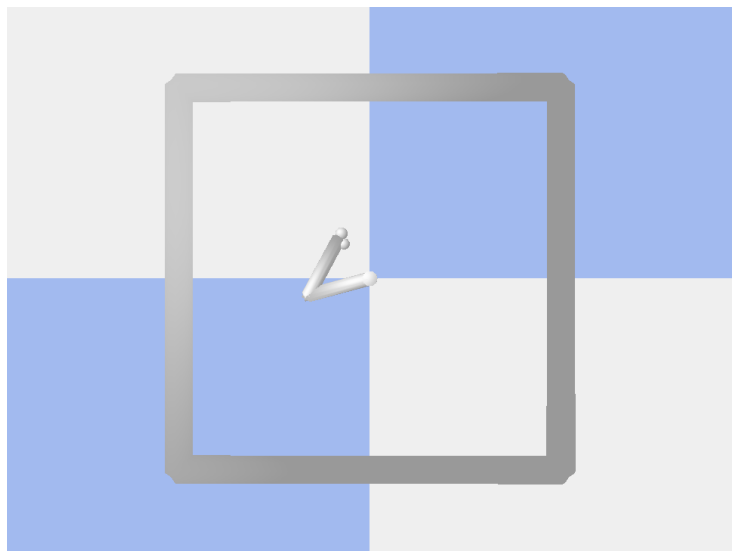

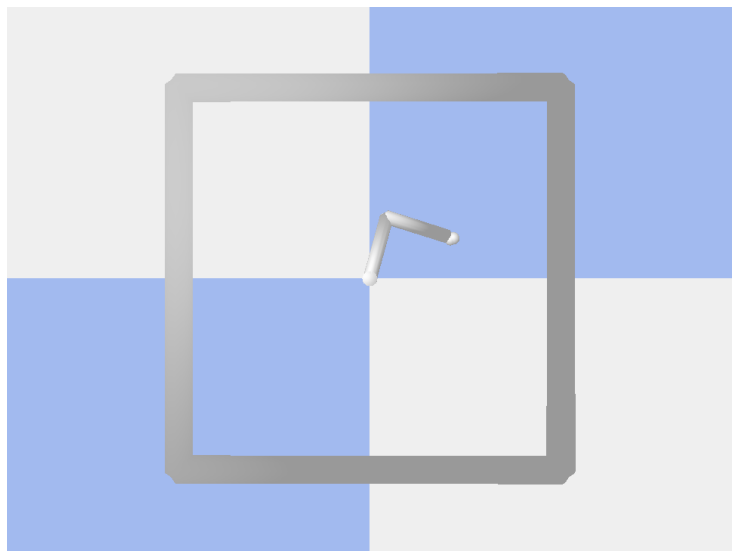

In [34]:
os.makedirs('../content/fused/rendering/', exist_ok=True)
render_agent_in_env(fused_model, eval_env, n_eval_episodes=5, path='../content/fused/rendering/', filename='retrained')

New model:

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=16.64 +/- 9.51


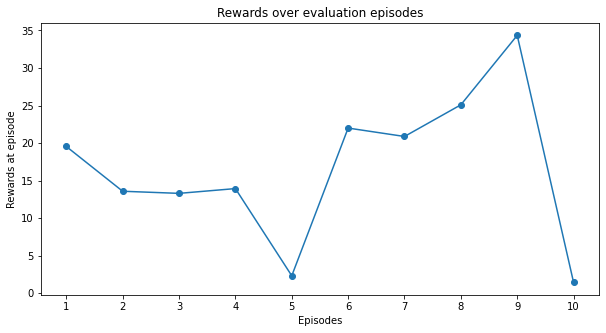

In [35]:
ep_rewards, ep_steps = evaluate_policy(new_model, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

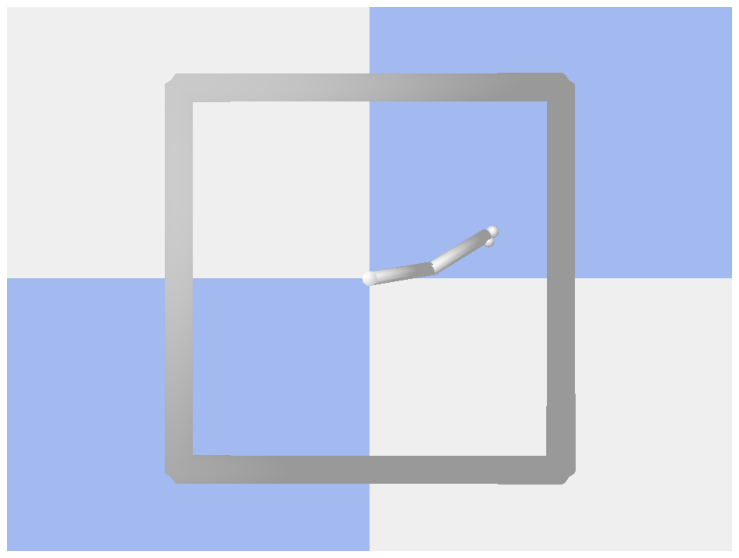

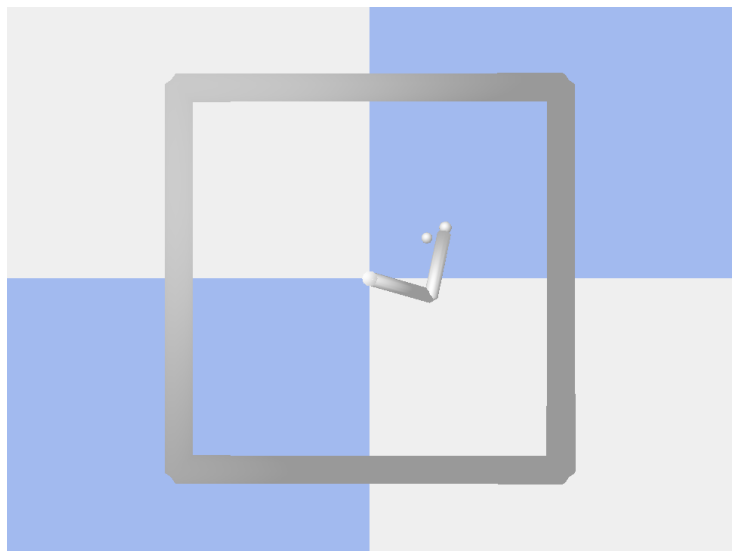

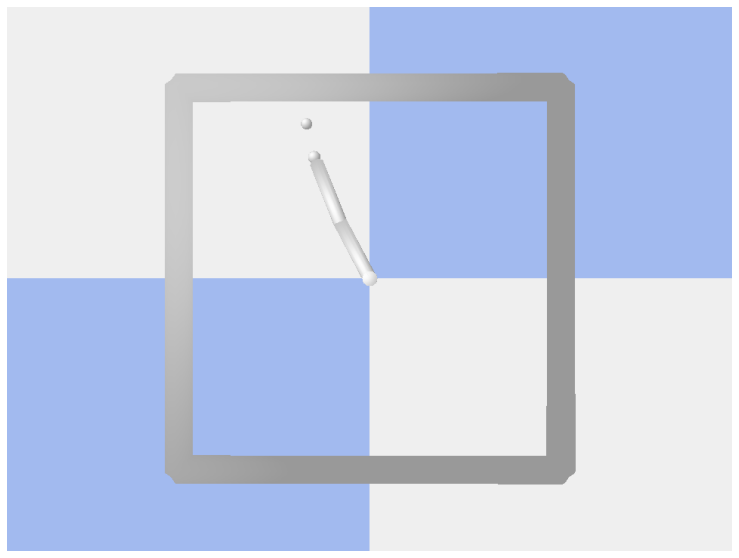

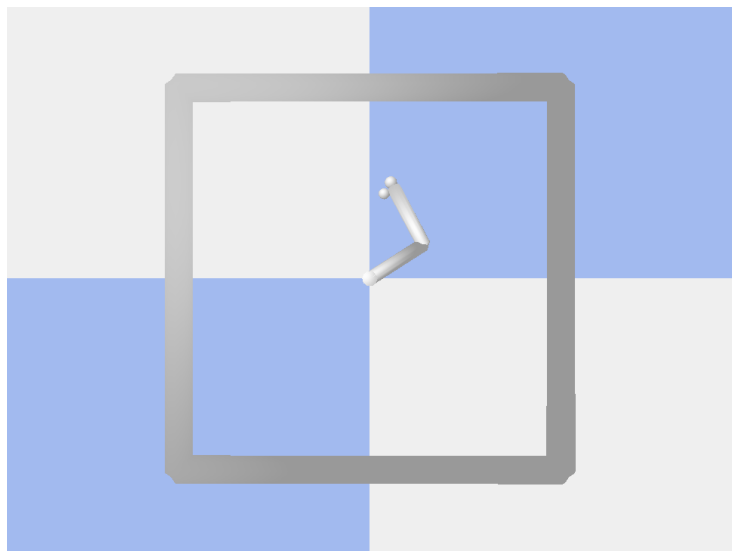

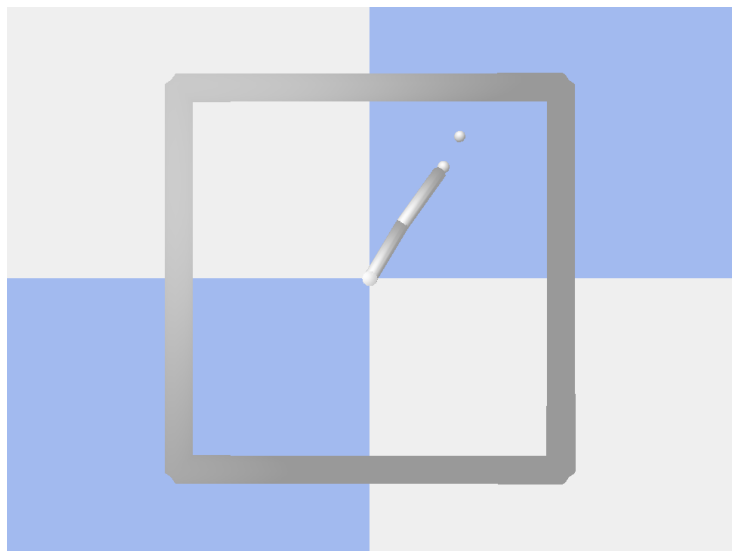

In [36]:
os.makedirs('../content/new-agent/rendering/', exist_ok=True)
render_agent_in_env(new_model, eval_env, n_eval_episodes=5, path='../content/new-agent/rendering/', filename='new-agent')

Retrained agent 1:

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=15.17 +/- 8.03


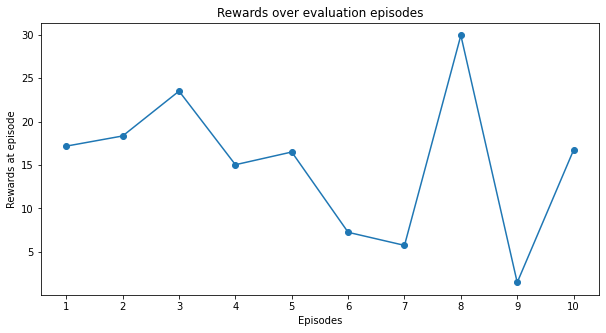

In [37]:
ep_rewards, ep_steps = evaluate_policy(model_one, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

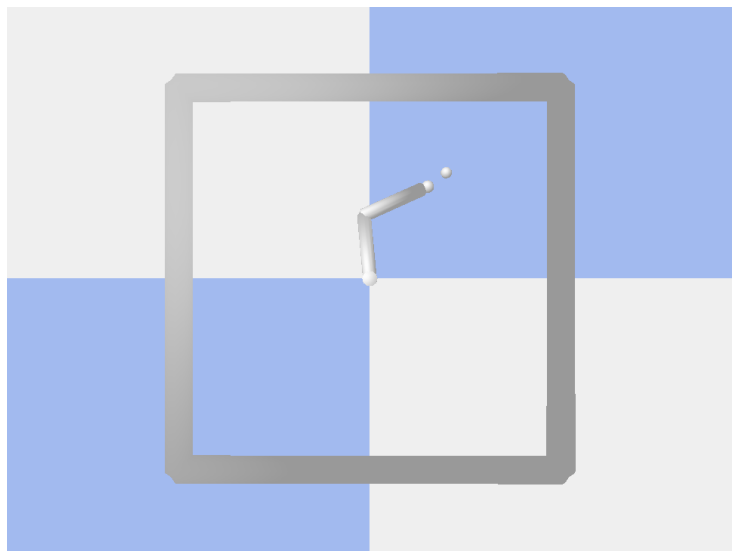

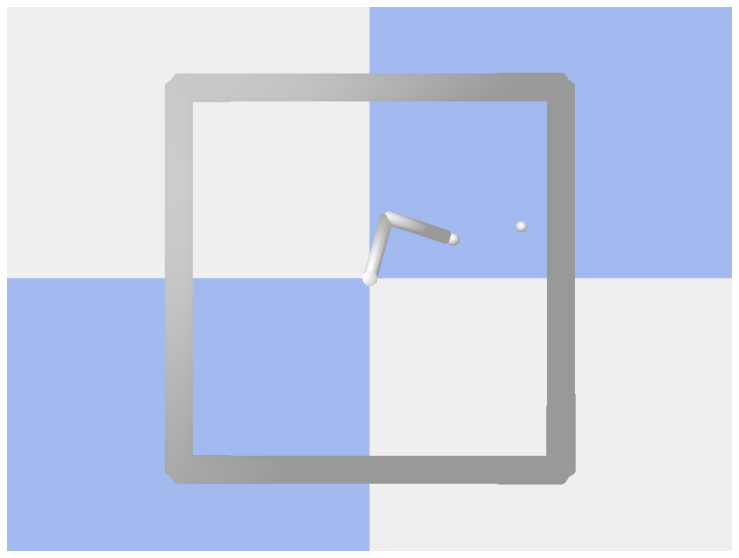

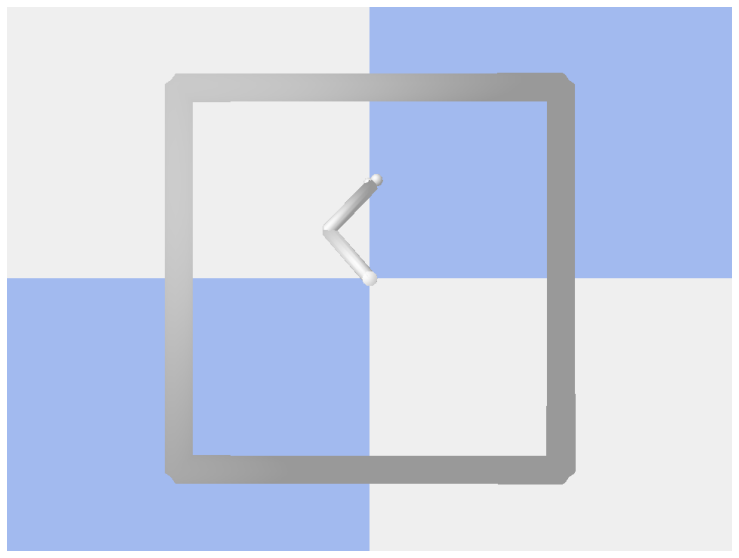

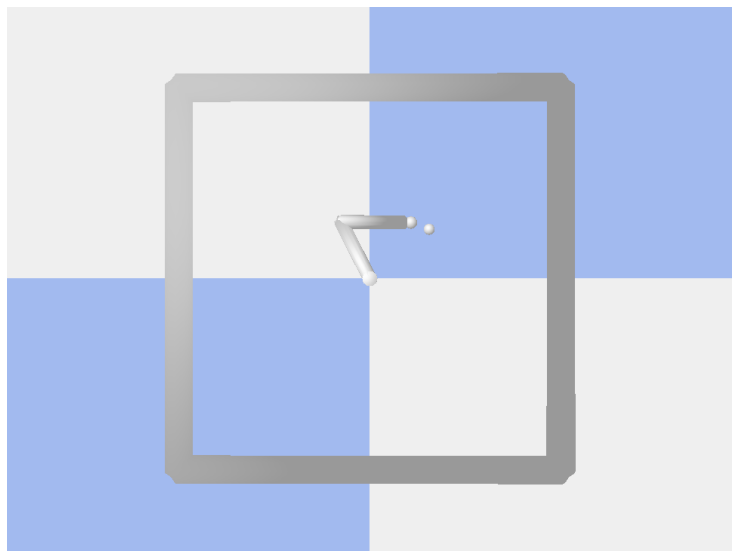

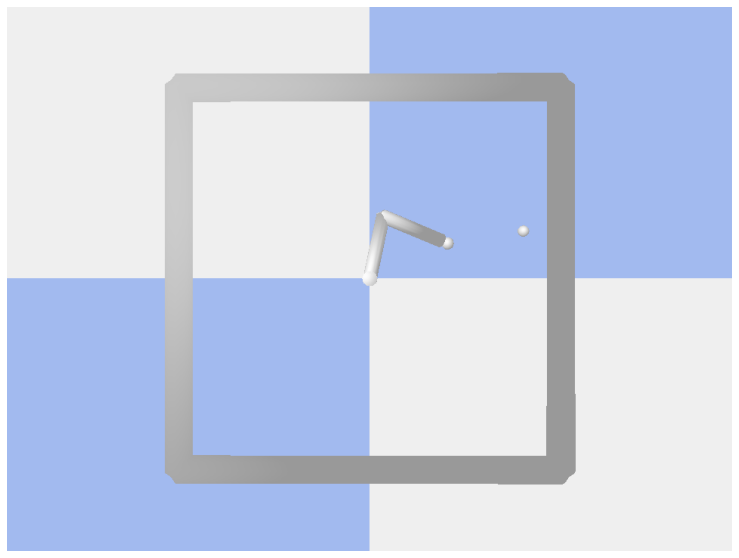

In [38]:
os.makedirs('../content/agent1/retraining/rendering/', exist_ok=True)
render_agent_in_env(model_one, eval_env, n_eval_episodes=5, path='../content/agent1/retraining/rendering/', filename='agent1-retrained')

Retrained agent 2:

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=16.59 +/- 7.92


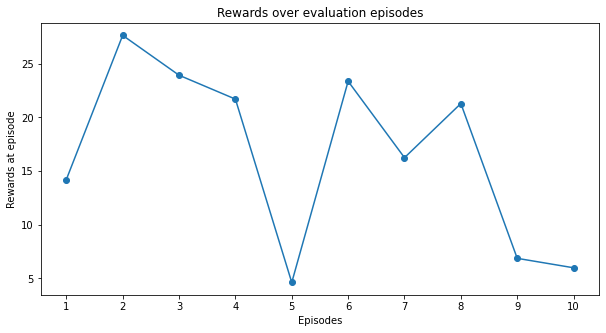

In [39]:
ep_rewards, ep_steps = evaluate_policy(model_two, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

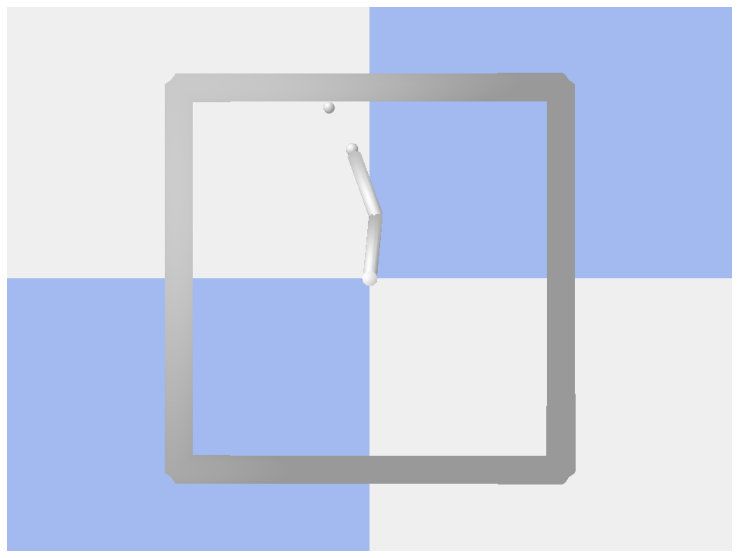

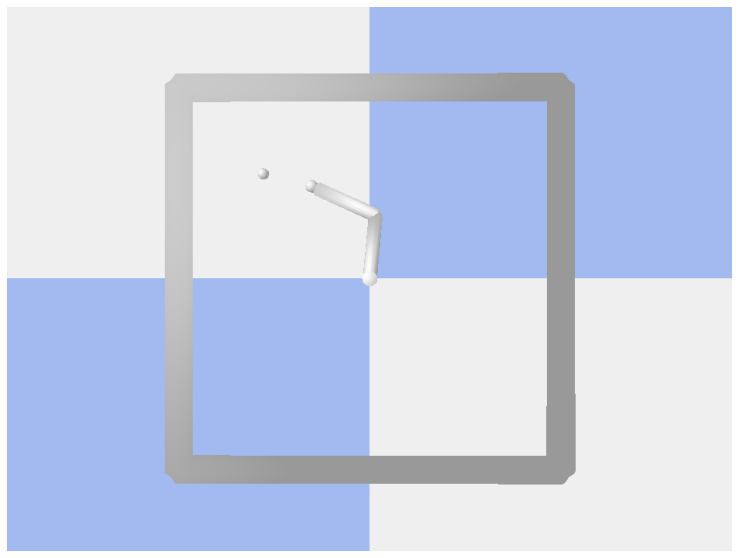

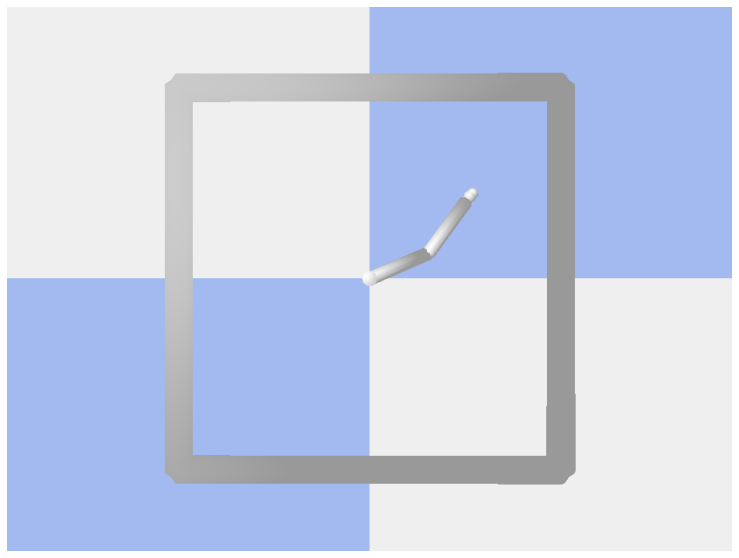

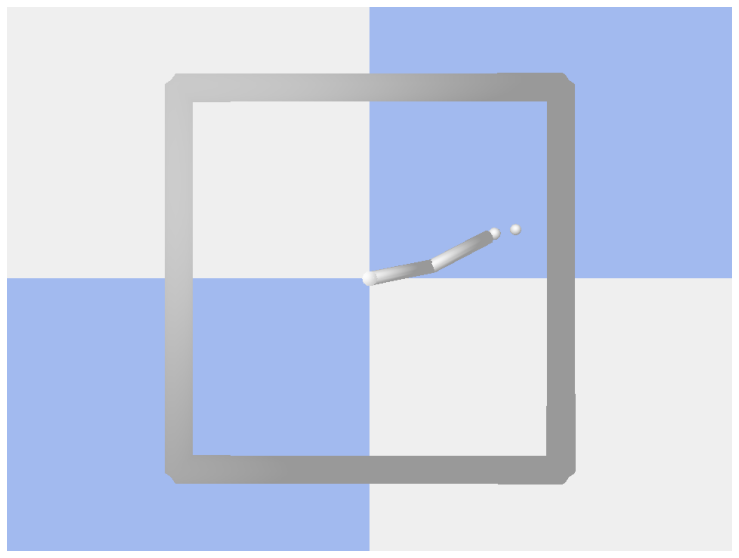

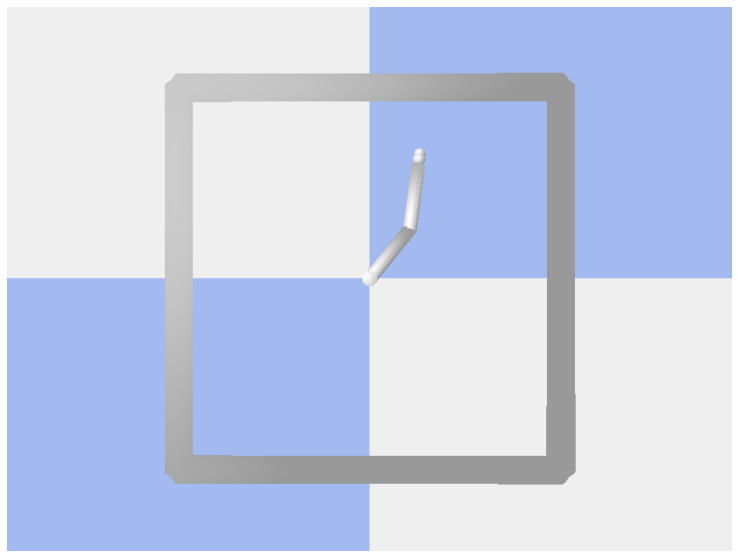

In [40]:
os.makedirs('../content/agent2/retraining/rendering/', exist_ok=True)
render_agent_in_env(model_two, eval_env, n_eval_episodes=5, path='../content/agent2/retraining/rendering/', filename='agent2-retrained')